# 401 CNN Improved


# QA
----
## **1. dropout作用是什么**
### Dropout可以作为训练深度神经网络的一种trick供选择。在每个训练批次中，通过忽略一半的特征检测器（让一半的隐层节点值为0），可以明显地减少过拟合现象。这种方式可以减少特征检测器（隐层节点）间的相互作用，检测器相互作用是指某些检测器依赖其他检测器才能发挥作用。Dropout说的简单一点就是：我们在前向传播的时候，让某个神经元的激活值以一定的概率p停止工作，这样可以使模型泛化性更强，因为它不会太依赖某些局部的特征。

-----

## **2. 谈谈dropout为什么有效？**
### dropout的思想继承自bagging方法。对神经元做选择从而得到结构上有所区别的网络，类似于bagging中选择部分数据训练多个学习器，最后都是对多个学习器的结果集成，都是起到提高泛化性能抑制过拟合的作用。
### 有论文说明了dropout是贝叶斯模型的近似，但是我没读懂。。。总之这一块不是很懂


----

## **3. 谈一下LSTM与GRU的异同**
### GRU和LSTM都是基础的RNN的变体，最大的相似之处就是， 在从t 到 t-1 的更新时都引入了加法，使得网络状态具有更好的传递性。这个加法的好处在于能防止梯度弥散，因此LSTM和GRU都比一般的RNN效果更好。性能在很多任务上不分伯仲。
### GRU 参数更少因此更容易收敛，但是数据集很大的情况下，LSTM表达性能更好。
### 从结构上来说，GRU只有两个门（update和reset），LSTM有三个门（forget，input，output），GRU直接将hidden state 传给下一个单元，而LSTM则用memory cell 把hidden state 包装起来。

----

## **4.CNN具备怎样的特性，为什么对于视觉信号处理这么有效？**
### CNN特征不需要人工设计，只需要给数据，可以当成黑匣子使用，适合用于比较复杂，难以人工设计特征的任务。总体来说，人工设计特征物理意义明确，有明确的意义，而CNN特征可以处理无法手动设计特征，或者场景较复杂的任务，从而利用大量的数据来训练较好的特征。同时，CNN共享卷积核，完成相同任务适用的参数也较少，收敛速度更快。

----

## **5. dropout层和激活层的顺序应该怎么设计，为什么？**
### 似乎一般都是先激活层再dropout的，但是没有找到详细的解释。

----
## **6. 401的tsne可视化的启示**
### tsne可视化是一种降维方法，将高维坐标集合映射到低维，以反映分布间差异程度的相对熵作为目标函数，通过动量的梯度下降进行优化。在点与点关系的衡量上采用了概率分布的形式，相对knn采用的切比雪夫距离能够更好的反映数据的局部特征。这里用tsne是一种方法，当然也可以用其他的方式，比如pca，总之最关键的是通过对最后一层网络参数和训练结果的关系进行可视化分析，可以较直观地地感知到网络分类的过程。




In [41]:
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
torch.manual_seed(1)    # reproducible

In [43]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded

In [44]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])


D:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


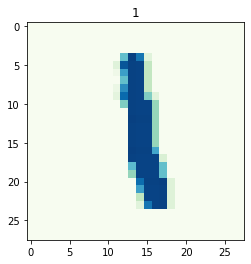

In [45]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
idx = 6
plt.imshow(train_data.train_data[idx].numpy(), cmap='GnBu')
plt.title('%i' % train_data.train_labels[idx])
plt.show()

In [46]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [47]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:6000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:6000]

D:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [65]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=32,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (32, 28, 28)
            nn.ReLU(),                      # activation
                # output shape (32, 28, 28)
        )
        self.conv2 = nn.Sequential(         # input shape (32, 28, 28)
            nn.Conv2d(32, 64, 5, 1, 2),     # output shape (64, 28, 28)
            nn.ReLU(),                      # activation               
        )
        self.conv3 = nn.Sequential(         # input shape (64, 28, 28)
            nn.Conv2d(64, 128, 5, 1, 2),     # output shape (128, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (128, 14, 14)
        )
        self.out = nn.Linear(128 * 14 * 14, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [66]:
cnn = CNN()
print(cnn)
cnn1 = CNN1()# net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [52]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [53]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
# %matplotlib widget
# from matplotlib import cm
# try: from sklearn.manifold import TSNE; HAS_SK = True
# except: HAS_SK = False; print('Please install sklearn for layer visualization')
# def plot_with_labels(lowDWeights, labels):
#     plt.cla()
#     X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
#     for x, y, s in zip(X, Y, labels):
#         c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
loss_plot = []
accu_plot = []
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        loss = loss.item()
        loss_plot.append(loss)
        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)  #2000*(128*7*7), 2000*10
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            accu_plot.append(accuracy)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
            # if HAS_SK:
            #     # Visualization of trained flatten layer (T-SNE)
            #     tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            #     plot_only = 500
            #     low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
            #     labels = test_y.numpy()[:plot_only]
            #     plot_with_labels(low_dim_embs, labels)
plt.ioff()


Epoch:  0 | train loss: 2.3028 | test accuracy: 0.24
Epoch:  0 | train loss: 0.2649 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1597 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2876 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1273 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1231 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0788 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2377 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1541 | test accuracy: 0.97
Epoch:  0 | train loss: 0.3249 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1332 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0550 | test accuracy: 0.98


In [67]:
optimizer1 = torch.optim.Adam(cnn1.parameters(), lr=LR)   # optimize all cnn parameters
loss_func1 = nn.CrossEntropyLoss()    

In [68]:
accu_plot1 = []
loss_plot1 = []
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn1(b_x)[0]               # cnn output
        loss = loss_func1(output, b_y)   # cross entropy loss
        optimizer1.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer1.step()                # apply gradients
        loss = loss.item()
        loss_plot1.append(loss)
        if step % 100 == 0:
            test_output, last_layer = cnn1(test_x)  #2000*(32*7*7), 2000*10
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            accu_plot1.append(accuracy)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
            # if HAS_SK:
            #     # Visualization of trained flatten layer (T-SNE)
            #     tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            #     plot_only = 500
            #     low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
            #     labels = test_y.numpy()[:plot_only]
            #     plot_with_labels(low_dim_embs, labels)



Epoch:  0 | train loss: 2.3003 | test accuracy: 0.20
Epoch:  0 | train loss: 0.1394 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1534 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0303 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0255 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0101 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0656 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0152 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0228 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0606 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0052 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0555 | test accuracy: 0.98


In [69]:

len(loss_plot1)

1200

In [70]:
import seaborn as sns
import pandas as pd

Text(0.5, 1.0, 'loss')

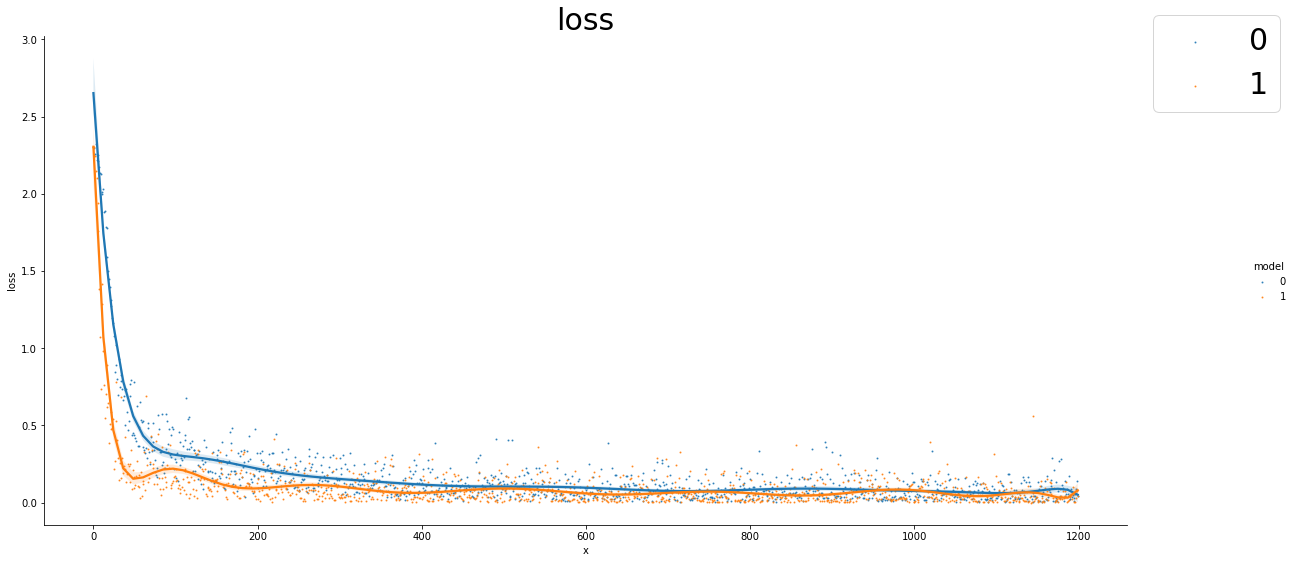

In [71]:

loss_plot_all = [i for i in range(1200)]+[i for i in range(1200)]
hue2 = [0 for i in range(1200)]+[1 for i in range(1200)]
df = pd.DataFrame({'x':loss_plot_all,'loss':loss_plot+loss_plot1,'model':hue2})

g = sns.lmplot(x = 'x', y = 'loss', data=df, hue='model',order=25,
            scatter_kws={"s": 1})
g.fig.set_size_inches((20,8))
g.fig.legend(fontsize=30)
plt.title('loss', fontsize=30)





Text(0.5, 1.0, 'accuracy')

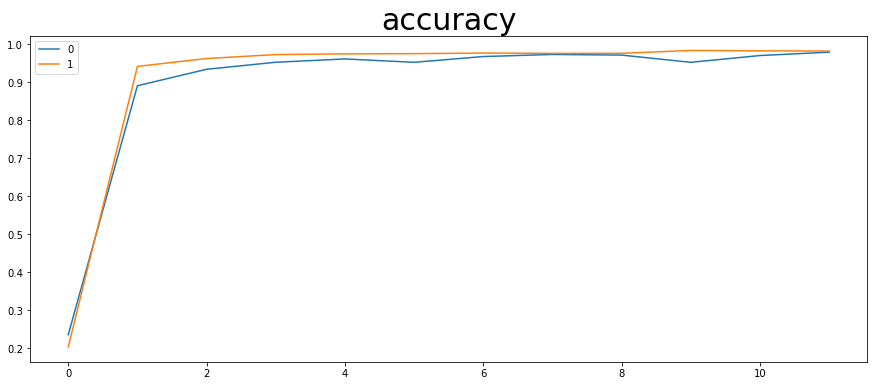

In [72]:
plt.figure(figsize=[15,6])
plt.plot(range(len(accu_plot)), accu_plot,label=0)
plt.plot(range(len(accu_plot1)), accu_plot1,label=1)
plt.legend()
plt.title('accuracy', fontsize=30)


In [73]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[0 7 4 7 7 7 7 9 7 4] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
